# Missing Sessions Analysis for Cell IDs

This notebook analyzes which sessions are missing for each cell ID from template_masks in the matched_cells structure.

In [13]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
# Load the match.pkl file
# Update this path to your actual match.pkl location
match_path = '/nrs/spruston/Gaby_imaging/raw/M54/multi_day_demix/registration_data/match.pkl'

with open(match_path, 'rb') as f:
    match_data = pickle.load(f)

# Extract the components
matched_cells = match_data[0]  # First element is matched_cells
matched_im = match_data[1]     # Second element is matched_im
template_masks = match_data[2] # Third element is template_masks
template_im = match_data[3]    # Fourth element is template_im

print(f"matched_cells has {len(matched_cells)} clusters")
print(f"template_masks has {len(template_masks)} masks")

matched_cells has 5972 clusters
template_masks has 5454 masks


In [4]:
# Extract the cell IDs from template_masks
template_ids = []
for mask in template_masks:
    if hasattr(mask, 'get') and mask.get('id') is not None:
        template_ids.append(mask['id'])
    elif isinstance(mask, dict) and 'id' in mask:
        template_ids.append(mask['id'])

# Remove duplicates and sort
template_ids = sorted(set(template_ids))
print(f"Found {len(template_ids)} unique cell IDs in template_masks")

# Show the first few IDs
print(f"First 10 IDs: {template_ids[:10]}")

Found 5454 unique cell IDs in template_masks
First 10 IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [5]:
# Determine all possible sessions
all_sessions = set()
for cluster in matched_cells:
    for cell in cluster:
        if hasattr(cell, 'get') and cell.get('session') is not None:
            all_sessions.add(cell['session'])
        elif isinstance(cell, dict) and 'session' in cell:
            all_sessions.add(cell['session'])

all_sessions = sorted(all_sessions)
print(f"Found {len(all_sessions)} unique sessions: {all_sessions}")

Found 35 unique sessions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [6]:
# Create a dictionary to map cell IDs to their clusters in matched_cells
id_to_cluster = {}
for i, cluster in enumerate(matched_cells):
    if not cluster:  # Skip empty clusters
        continue
        
    # Get the cell ID (should be the same across the cluster)
    cell_id = None
    if hasattr(cluster[0], 'get') and cluster[0].get('id') is not None:
        cell_id = cluster[0]['id']
    elif isinstance(cluster[0], dict) and 'id' in cluster[0]:
        cell_id = cluster[0]['id']
        
    if cell_id is not None:
        id_to_cluster[cell_id] = i

print(f"Mapped {len(id_to_cluster)} cell IDs to their clusters")

Mapped 5972 cell IDs to their clusters


In [7]:
# Create a structure showing which sessions each template ID is missing
missing_sessions_by_id = {}

for template_id in template_ids:
    # Skip if this ID isn't in matched_cells
    if template_id not in id_to_cluster:
        missing_sessions_by_id[template_id] = all_sessions  # Missing all sessions
        continue
        
    # Get the cluster for this ID
    cluster_idx = id_to_cluster[template_id]
    cluster = matched_cells[cluster_idx]
    
    # Find which sessions this ID appears in
    present_sessions = set()
    for cell in cluster:
        if hasattr(cell, 'get') and cell.get('session') is not None:
            present_sessions.add(cell['session'])
        elif isinstance(cell, dict) and 'session' in cell:
            present_sessions.add(cell['session'])
    
    # Calculate missing sessions
    missing_sessions = sorted(set(all_sessions) - present_sessions)
    missing_sessions_by_id[template_id] = missing_sessions

print(f"Analyzed missing sessions for {len(missing_sessions_by_id)} template IDs")

Analyzed missing sessions for 5454 template IDs


In [47]:
# Display results for the first 10 template IDs
print("Missing sessions by template ID (first 10):")
for i, (template_id, missing) in enumerate(list(missing_sessions_by_id.items())[10:22]):
    print(f"ID {template_id}: Missing {len(missing)}/{len(all_sessions)} sessions: {missing}")

Missing sessions by template ID (first 10):
ID 11: Missing 15/35 sessions: [0, 1, 2, 5, 10, 12, 14, 16, 17, 19, 20, 22, 23, 27, 29]
ID 12: Missing 10/35 sessions: [0, 1, 10, 11, 16, 17, 18, 19, 20, 30]
ID 13: Missing 13/35 sessions: [0, 12, 14, 16, 17, 19, 20, 21, 22, 23, 27, 29, 34]
ID 14: Missing 17/35 sessions: [0, 2, 3, 5, 10, 11, 12, 15, 16, 17, 18, 19, 20, 22, 23, 33, 34]
ID 15: Missing 15/35 sessions: [0, 1, 2, 3, 5, 10, 11, 12, 14, 16, 17, 19, 20, 22, 23]
ID 16: Missing 16/35 sessions: [0, 1, 2, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 23, 30, 31]
ID 17: Missing 17/35 sessions: [0, 1, 2, 3, 5, 7, 10, 11, 12, 14, 16, 17, 19, 20, 22, 23, 27]
ID 18: Missing 17/35 sessions: [0, 1, 2, 5, 7, 8, 10, 12, 14, 16, 17, 19, 20, 22, 23, 27, 32]
ID 19: Missing 8/35 sessions: [0, 12, 16, 17, 19, 22, 23, 34]
ID 20: Missing 7/35 sessions: [0, 10, 16, 17, 19, 20, 30]
ID 21: Missing 10/35 sessions: [0, 5, 10, 14, 16, 17, 19, 20, 23, 34]
ID 22: Missing 9/35 sessions: [0, 5, 10, 14, 16, 17, 19, 22, 

In [9]:
# Count how many IDs are missing each session
session_missing_counts = defaultdict(int)
for template_id, missing in missing_sessions_by_id.items():
    for session in missing:
        session_missing_counts[session] += 1

# Sort by session number
sorted_counts = [(session, count) for session, count in sorted(session_missing_counts.items())]

# Display the counts
print("Number of template IDs missing each session:")
for session, count in sorted_counts:
    percentage = (count / len(template_ids)) * 100
    print(f"Session {session}: {count} IDs ({percentage:.1f}% of all template IDs)")

Number of template IDs missing each session:
Session 0: 2868 IDs (52.6% of all template IDs)
Session 1: 2453 IDs (45.0% of all template IDs)
Session 2: 1879 IDs (34.5% of all template IDs)
Session 3: 3159 IDs (57.9% of all template IDs)
Session 4: 1560 IDs (28.6% of all template IDs)
Session 5: 1553 IDs (28.5% of all template IDs)
Session 6: 663 IDs (12.2% of all template IDs)
Session 7: 556 IDs (10.2% of all template IDs)
Session 8: 568 IDs (10.4% of all template IDs)
Session 9: 603 IDs (11.1% of all template IDs)
Session 10: 2118 IDs (38.8% of all template IDs)
Session 11: 1843 IDs (33.8% of all template IDs)
Session 12: 1529 IDs (28.0% of all template IDs)
Session 13: 486 IDs (8.9% of all template IDs)
Session 14: 1298 IDs (23.8% of all template IDs)
Session 15: 1220 IDs (22.4% of all template IDs)
Session 16: 2840 IDs (52.1% of all template IDs)
Session 17: 2407 IDs (44.1% of all template IDs)
Session 18: 1391 IDs (25.5% of all template IDs)
Session 19: 3116 IDs (57.1% of all templ

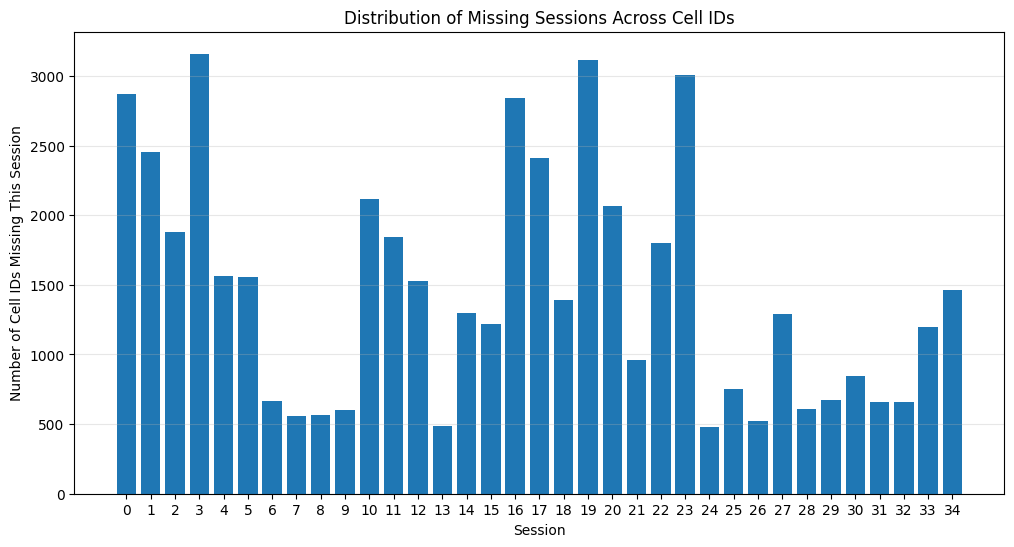

In [10]:
# Visualize the distribution of missing sessions
plt.figure(figsize=(12, 6))
sessions = [s for s, _ in sorted_counts]
counts = [c for _, c in sorted_counts]

plt.bar(sessions, counts)
plt.xlabel('Session')
plt.ylabel('Number of Cell IDs Missing This Session')
plt.title('Distribution of Missing Sessions Across Cell IDs')
plt.xticks(sessions)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [11]:
# Find cell IDs that are missing specific target sessions (e.g., 7, 8, 9)
def find_ids_missing_target_sessions(missing_sessions_by_id, target_sessions=[7, 8, 9]):
    target_ids = []
    
    for template_id, missing in missing_sessions_by_id.items():
        # Check if any target session is in the missing sessions
        if any(session in missing for session in target_sessions):
            target_ids.append({
                'id': template_id,
                'missing_targets': [s for s in target_sessions if s in missing],
                'all_missing': missing,
                'missing_count': len(missing),
                'present_count': len(all_sessions) - len(missing)
            })
    
    # Sort by present_count (descending) to find IDs present in most sessions
    return sorted(target_ids, key=lambda x: x['present_count'], reverse=True)

# Find IDs missing sessions 7, 8, or 9
target_sessions = [7, 8, 9]
results = find_ids_missing_target_sessions(missing_sessions_by_id, target_sessions)

print(f"Found {len(results)} cell IDs missing at least one of sessions {target_sessions}")

# Display the top results (IDs missing target sessions but present in most other sessions)
print("\nTop results (IDs present in most sessions but missing target sessions):")
for i, result in enumerate(results[:10]):
    print(f"\nResult {i+1}:")
    print(f"ID: {result['id']}")
    print(f"Present in {result['present_count']}/{len(all_sessions)} sessions")
    print(f"Missing target sessions: {result['missing_targets']}")
    print(f"All missing sessions: {result['all_missing']}")

Found 1208 cell IDs missing at least one of sessions [7, 8, 9]

Top results (IDs present in most sessions but missing target sessions):

Result 1:
ID: 5393
Present in 34/35 sessions
Missing target sessions: [8]
All missing sessions: [8]

Result 2:
ID: 3137
Present in 33/35 sessions
Missing target sessions: [7]
All missing sessions: [7, 27]

Result 3:
ID: 4438
Present in 33/35 sessions
Missing target sessions: [9]
All missing sessions: [9, 23]

Result 4:
ID: 944
Present in 32/35 sessions
Missing target sessions: [8]
All missing sessions: [0, 8, 23]

Result 5:
ID: 1728
Present in 32/35 sessions
Missing target sessions: [7, 9]
All missing sessions: [7, 9, 17]

Result 6:
ID: 2849
Present in 32/35 sessions
Missing target sessions: [7, 8]
All missing sessions: [7, 8, 11]

Result 7:
ID: 3025
Present in 32/35 sessions
Missing target sessions: [7]
All missing sessions: [1, 5, 7]

Result 8:
ID: 4198
Present in 32/35 sessions
Missing target sessions: [8]
All missing sessions: [8, 23, 25]

Result 

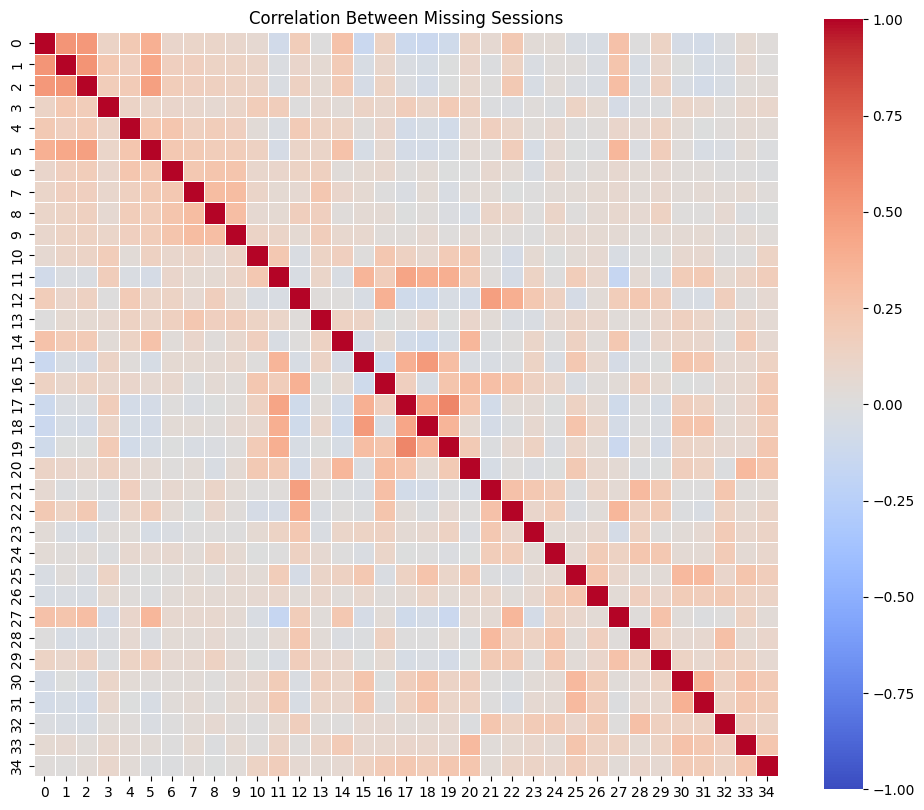

Found 0 clusters of sessions that are often missing together:


In [15]:
# Create a function to find clusters of sessions that are often missing together
def find_session_clusters(missing_sessions_by_id, min_correlation=0.7):
    # Create a binary matrix: rows=IDs, columns=sessions, value=1 if missing, 0 if present
    matrix_data = []
    for template_id, missing in missing_sessions_by_id.items():
        # Create a row with 1s for missing sessions, 0s for present sessions
        row = [1 if session in missing else 0 for session in all_sessions]
        matrix_data.append(row)
    
    # Convert to numpy array
    matrix = np.array(matrix_data)
    
    # Calculate correlation between sessions
    # If sessions are often missing together, their correlation will be high
    session_corr = np.corrcoef(matrix.T)
    
    # Create a DataFrame for the correlation matrix
    corr_df = pd.DataFrame(session_corr, index=all_sessions, columns=all_sessions)
    
    # Visualize correlation between sessions
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_df, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, linewidths=0.5)
    plt.title('Correlation Between Missing Sessions')
    plt.show()
    
    # Find clusters of sessions that are often missing together
    session_clusters = []
    used_sessions = set()
    
    for i, session1 in enumerate(all_sessions):
        if session1 in used_sessions:
            continue
            
        cluster = [session1]
        used_sessions.add(session1)
        
        for j, session2 in enumerate(all_sessions):
            if i != j and session2 not in used_sessions and corr_df.loc[session1, session2] >= min_correlation:
                cluster.append(session2)
                used_sessions.add(session2)
        
        if len(cluster) > 1:  # Only add clusters with at least 2 sessions
            session_clusters.append(cluster)
    
    # Add remaining sessions as individual clusters
    for session in all_sessions:
        if session not in used_sessions:
            session_clusters.append([session])
    
    return session_clusters, corr_df

# Find and display session clusters
session_clusters, session_corr = find_session_clusters(missing_sessions_by_id, min_correlation=0.7)

print(f"Found {len(session_clusters)} clusters of sessions that are often missing together:")
for i, cluster in enumerate(session_clusters):
    print(f"Cluster {i+1}: {cluster}")

In [34]:
import pickle
# -----------------------------
#
#  LOAD state if needed
#   (uncomment these if your variables aren't already in memory)
# -----------------------------
with open('/nrs/spruston/Gaby_imaging/raw/M54/multi_day_demix/registration_data/import.pkl','rb') as f:
    sessions, images, cells, im_size, label_im = pickle.load(f)
with open('/nrs/spruston/Gaby_imaging/raw/M54/multi_day_demix/registration_data/match.pkl','rb') as f:
    matched_cells, matched_im, template_masks, template_im = pickle.load(f)


with open('/nrs/spruston/Gaby_imaging/raw/M54/multi_day_demix/registration_data/register.pkl','rb') as f:
    deforms, trans_images, trans_masks, trans_label_im = pickle.load(f)

with open('/nrs/spruston/Gaby_imaging/raw/M54/multi_day_demix/registration_data/filter.pkl','rb') as f:
    deform_masks, deform_label_ims, deform_lam_ims, template_masks2 = pickle.load(f)



In [37]:
deform_label_ims[s].shape

(550, 1856)

Session 7: suggested vmin=111.996, vmax=341.938, crop=(123, 134)


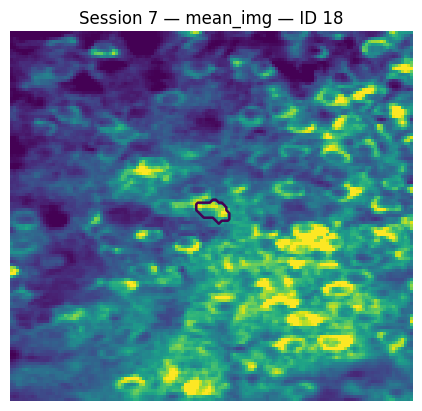

Session 8: suggested vmin=114.633, vmax=347.623, crop=(123, 134)


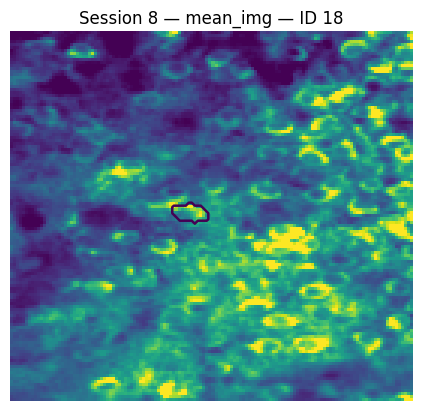

Session 9: suggested vmin=77.961, vmax=211.791, crop=(123, 134)


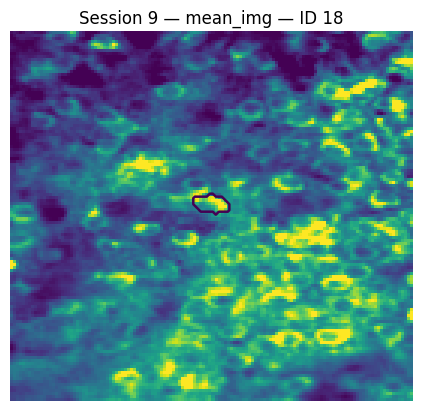

In [57]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
CELL_ID = 18            # <- only plot this ID (common cells projected back)
BG_KEY  = "mean_img"       # "mean_img" | "enhanced_img" | "max_img"
PCT     = (2, 98)          # robust percentile range for intensity images
MARGIN  = 50               # extra pixels around union bbox
# If you want to limit to specific sessions, set e.g. SESSIONS = [7, 8, 9]
SESSIONS = None            # None => auto-use all sessions; or provide list of ints


# -----------------------------
# VALIDATE SHAPES / SESSIONS
# -----------------------------
num_sessions = len(images)
if SESSIONS is None:
    SESSIONS = list(range(num_sessions))

# sanity: image and label shapes match
for s in SESSIONS:
    bg = images[s][BG_KEY]
    lab = deform_label_ims[s]
    if bg.shape != lab.shape:
        raise ValueError(f"Shape mismatch for session {s}: {BG_KEY}={bg.shape}, labels={lab.shape}")

# -----------------------------
# FIND WHERE ID 9 EXISTS (in SESSION SPACE)
# -----------------------------
present_sessions = []
coords_y = []
coords_x = []
for s in SESSIONS:
    m = (deform_label_ims[s] == CELL_ID)
    if m.any():
        present_sessions.append(s)
        y, x = np.where(m)
        coords_y.append(y)
        coords_x.append(x)

if not present_sessions:
    raise RuntimeError(f"Cell ID {CELL_ID} not present in any of the requested sessions {SESSIONS}.")

# -----------------------------
# UNION BBOX ACROSS SESSIONS + MARGIN
# -----------------------------
H, W = deform_label_ims[0].shape
y_all = np.concatenate(coords_y)
x_all = np.concatenate(coords_x)
y0, y1 = y_all.min(), y_all.max()
x0, x1 = x_all.min(), x_all.max()
y0 = max(0, y0 - MARGIN); y1 = min(H-1, y1 + MARGIN)
x0 = max(0, x0 - MARGIN); x1 = min(W-1, x1 + MARGIN)

# -----------------------------
# HELPER: robust display range
# -----------------------------
def suggested_range_intensity(img2d, pct=(2, 98)):
    vmin, vmax = np.percentile(img2d, pct)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = float(img2d.min()), float(img2d.max())
    return float(vmin), float(vmax)

# -----------------------------
# PLOT EACH PRESENT SESSION: mean image + ID9 outline
# -----------------------------
for s in [7,8,9]:
    bg = images[s][BG_KEY]
    lab = deform_label_ims[s]

    bg_roi  = bg[y0:y1+1, x0:x1+1]
    id_roi  = (lab == CELL_ID)[y0:y1+1, x0:x1+1]

    vmin, vmax = suggested_range_intensity(bg_roi, PCT)
    print(f"Session {s}: suggested vmin={vmin:.3f}, vmax={vmax:.3f}, crop={bg_roi.shape}")

    plt.figure()
    plt.title(f"Session {s} — {BG_KEY} — ID {CELL_ID}")
    plt.imshow(bg_roi, vmin=vmin, vmax=vmax, interpolation='nearest')
    plt.contour(id_roi.astype(float), levels=[0.5], linewidths=1.8)  # solid outline of ID9 only
    plt.axis('off')
    plt.show()

In [56]:
matched_cells[5]

[{'xpix': array([191, 192, 193, 194, 195, 196, 190, 191, 192, 193, 194, 195, 196,
         197, 198, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 191,
         192, 193, 194, 195, 196, 197, 198, 199, 190, 191, 192, 193, 194,
         195, 196, 197, 198, 199, 190, 191, 192, 193, 194, 195, 196, 197,
         198, 190, 191, 192, 193, 194, 195, 190, 191, 192, 193, 194]),
  'ypix': array([106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107,
         107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109,
         109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110,
         110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111,
         111, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113]),
  'ipix': array([196927, 196928, 196929, 196930, 196931, 196932, 198782, 198783,
         198784, 198785, 198786, 198787, 198788, 198789, 198790, 200638,
         200639, 200640, 200641, 200642, 200643, 200644, 200645, 200646,
         200647, 202495

In [58]:

def iou_from_ipix(a_ipix, b_ipix):
    """Compute IoU between two masks given their linear index arrays."""
    a = np.asarray(a_ipix)
    b = np.asarray(b_ipix)
    # Assume indices are unique (Suite2p ipix); if not, unique() is cheap
    a = np.unique(a); b = np.unique(b)
    inter = np.intersect1d(a, b, assume_unique=True).size
    if inter == 0:
        return 0.0
    union = a.size + b.size - inter
    return inter / union

def map_common_to_session_rois(common_id, cells, deform_masks, sessions=None, min_iou=0.2):
    """
    For a given common/template ID, find the best-matching native ROI in each session
    by IoU overlap between the back-projected template mask (deform_masks) and cells[s].
    
    Returns: { session_index: { 'cells_index': int or None,
                                'iou': float or 0.0,
                                'cells_mask': dict or None,
                                'template_mask': dict or None } }
    """
    out = {}
    num_sessions = len(cells)
    if sessions is None:
        sessions = range(num_sessions)
    for s in sessions:
        # find the back-projected template mask for this common_id in session s
        templ = None
        for m in deform_masks[s]:
            if m.get('id', None) == common_id:
                templ = m
                break
        if templ is None:
            out[s] = {'cells_index': None, 'iou': 0.0, 'cells_mask': None, 'template_mask': None}
            continue

        best_iou = 0.0
        best_idx = None
        best_mask = None
        t_ipix = templ['ipix']

        for i, cm in enumerate(cells[s]):
            # cells[s] are native masks from Suite2p; they typically have ipix/xpix/ypix/med...
            iou = iou_from_ipix(t_ipix, cm['ipix'])
            if iou > best_iou:
                best_iou = iou
                best_idx = i
                best_mask = cm

        if best_iou >= min_iou and best_idx is not None:
            out[s] = {'cells_index': best_idx, 'iou': float(best_iou),
                      'cells_mask': best_mask, 'template_mask': templ}
        else:
            out[s] = {'cells_index': None, 'iou': float(best_iou),
                      'cells_mask': None, 'template_mask': templ}
    return out


mapping = map_common_to_session_rois(9, cells, deform_masks, sessions=[7,8,9], min_iou=0.2)
for s, info in mapping.items():
    print(f"Session {s}: cells_index={info['cells_index']}, IoU={info['iou']:.3f}")

Session 7: cells_index=None, IoU=0.000
Session 8: cells_index=None, IoU=0.000
Session 9: cells_index=None, IoU=0.000
